In [22]:
import numpy as np
import pytreenet as ptn
from copy import deepcopy
from scipy.linalg import expm

# Initial product state

In [23]:
def product_state(ttn, bond_dim=0 , physical_dim= 2):
    product_state = deepcopy(ttn)
    A = np.array([1/np.sqrt(2),1/np.sqrt(2)])
    #A = np.array([0,1])
    #A = np.array(coherent(physical_dim , alpha).full())   
    for node_id in product_state.nodes.keys():
        n = product_state.tensors[node_id].ndim - 1
        tensor = A.reshape((1,) * n + (physical_dim,))
        T = np.pad(tensor, n*((0, bond_dim),) + ((0, 0),))
        product_state.tensors[node_id] = T
        product_state.nodes[node_id].link_tensor(T)  
    return product_state

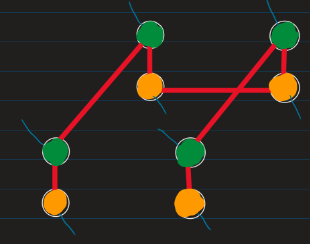

In [24]:
# bra in not ket.conj()

d = 2
shapes = {
    (0, 0): (3, d),
    (0, 1): (3, d),
    (1, 0): (3, 5, d),
    (1, 1): (3, 5, d)}


vertices = {
    f"Site({i},{j})": ptn.random_tensor_node(shapes[(i, j)], 
                     identifier=f"Site({i},{j})") 
                     for i in range(2) for j in range(2)
}

shapes = {
    (0, 0): (3, 4, d),
    (0, 1): (3, 6, d),
    (1, 0): (3, 4, d),
    (1, 1): (3, 6, d),}

vertices.update({
    f"Node({i},{j})": ptn.random_tensor_node(shapes[(i, j)], 
                       identifier=f"Node({i},{j})") 
                       for i in range(2) for j in range(2)
})

vectorized_rho = ptn.TreeTensorNetworkState()
vectorized_rho.add_root(vertices["Site(0,0)"][0], vertices["Site(0,0)"][1])

connections = [
    ("Site(0,0)", "Node(0,0)", 0, 0),
    ("Node(0,0)", "Node(1,0)", 1, 1),
    ("Node(1,0)", "Site(1,0)", 1, 0),
    ("Site(1,0)", "Site(1,1)", 1, 1),
    ("Site(1,1)", "Node(1,1)", 1, 0),
    ("Node(1,1)", "Node(0,1)", 1, 1),
    ("Node(0,1)", "Site(0,1)", 1, 0),]

for (parent, child, parent_leg, child_leg) in connections:
    vectorized_rho.add_child_to_parent(vertices[child][0], vertices[child][1], child_leg, parent, parent_leg)

vectorized_rho = product_state(vectorized_rho , bond_dim=1, physical_dim = d)    

# Normalize state

In [25]:
vectorized_rho.canonical_form('Site(0,1)', ptn.SplitMode.FULL)
vectorized_rho.canonical_form('Site(0,0)', ptn.SplitMode.REDUCED)
vectorized_rho.canonical_form('Site(0,1)', ptn.SplitMode.REDUCED)

norm = ptn.trace_rho(vectorized_rho)
print(norm)
T = vectorized_rho.tensors['Site(0,1)'].astype(complex)
T /= norm
vectorized_rho.tensors['Site(0,1)'] = T
vectorized_rho.nodes['Site(0,1)'].link_tensor(T)

ptn.trace_rho(vectorized_rho)

(0.9999999999999991+0j)


(1+0j)

# 1TDVP

In [26]:
t = 0.4
u = 0.8
m = 0.4
creation_op, annihilation_op, number_op = ptn.bosonic_operators(d)
L = annihilation_op
gamma = 1.2

# TTNO : Liouville operator 
H1 = ptn.BH_Liouville(t, u, gamma, m ,L, 2, 2, d)
H1 = H1.pad_with_identities(vectorized_rho , symbolic= True)
L_fancy = ptn.TTNO.from_hamiltonian(H1, vectorized_rho)
L_fancy = L_fancy.conjugate()


config= ptn.TTNTimeEvolutionConfig(record_bond_dim = False,
                                   Lanczos_evolution= False)

tdvp_Lindblad = ptn.FirstOrderOneSiteTDVP(initial_state = vectorized_rho,
                                            hamiltonian = L_fancy,
                                            time_step_size = 0.01,
                                            final_time = 1,
                                            operators = [],
                                            config = config)


# Results

 #########     Initial state     ##########
 tr(rho ** 2)         :  (1+0j)
 tr(rho)              :  (1+0j)


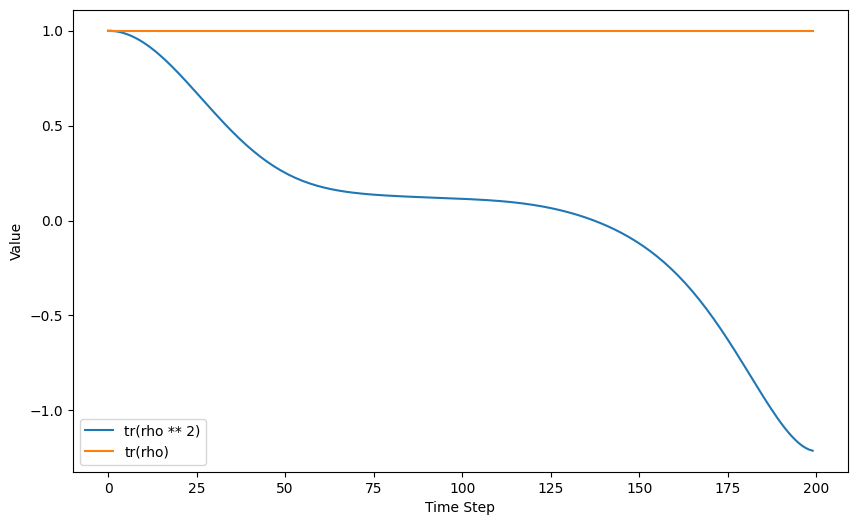

In [27]:
print(" #########     Initial state     ##########") 
print(" tr(rho ** 2)         : " , ptn.trace_rho_squared(tdvp_Lindblad.state ) )
print(" tr(rho)              : " , ptn.trace_rho(tdvp_Lindblad.state ) )
tr_rho_sq = []
tr_rho= []
for i in range(200):
    tr_rho_sq.append(ptn.trace_rho_squared(tdvp_Lindblad.state))
    tr_rho.append(ptn.trace_rho(tdvp_Lindblad.state))
    tdvp_Lindblad.run_one_time_step()
    tdvp_Lindblad._reset_for_next_time_step()

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(tr_rho_sq, label='tr(rho ** 2)')
plt.plot(tr_rho, label='tr(rho)')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()